In [32]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

In [33]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [34]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [35]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        features = image_name.split('/')[-2:]
        
        masktoint = {'m' : 0, 'i' : 1, 'n' : 2}
        gendertoint = {'male' : 0, 'female' : 1}
        
        mask = masktoint[features[1][0]]
        age = int(features[0].split('_')[-1])
        gender = gendertoint[features[0].split('_')[1]]
        
        if age >= 58: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, (mask, gender, age)

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [36]:
from torch.utils.data.dataset import random_split
tfms = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
        A.GaussNoise(p=0.5),
        A.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
tfms_test = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
dataset = TrainDataset(train_dir, transform=tfms)
train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.8),int(len(dataset)*0.2)])
# print(len(dataset))
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=False)
val_loader   = DataLoader(dataset=val_dataset, num_workers=4, batch_size=32)

In [37]:
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

## Model

In [38]:
from efficientnet_pytorch import EfficientNet

class Way3(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = EfficientNet.from_pretrained('efficientnet-b6', num_classes=512).to(device)
        self.mask = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.gender = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        self.age = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.best_f1 = 0
        
    def forward(self, x):
        features = self.convnet(x)
        mask = self.mask(features)
        gender = self.gender(features)
        age = self.age(features)
        
        return mask, gender, age
    
model = Way3().to(device)

Loaded pretrained weights for efficientnet-b6


In [39]:
import torch.optim as optim
lr = 1.8e-4

w_gender = torch.tensor([1.4, 1.0]).to(device)
w_age = torch.tensor([1.0, 1.2, 3.5]).to(device)

criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss(w_gender)
age_criterion = nn.CrossEntropyLoss(weight=w_age)
# b_criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85, verbose=True)

Adjusting learning rate of group 0 to 1.8000e-04.


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check(loader, length, model, device):
    model.eval()
    y_true = []
    y_predicted = []

    m_acc = []
    g_acc = []
    a_acc = []
    with torch.no_grad():
        for (inputs, (m, g, a)) in val_loader:
            for mask, gender, age in zip(m, g, a):
                answer = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_true.append(answer)

            inputs = inputs.to(device=device)
            m = m.to(device)
            g = g.to(device)
            a = a.to(device)

            m_pred, g_pred, a_pred = model(inputs)

            m_argmax = m_pred.detach().cpu().numpy().argmax(1)
            g_argmax = g_pred.detach().cpu().numpy().argmax(1)
            a_argmax = a_pred.detach().cpu().numpy().argmax(1)

            m_acc.append(accuracy_score(m_argmax, m.detach().cpu().numpy()))
            g_acc.append(accuracy_score(g_argmax, g.detach().cpu().numpy()))
            a_acc.append(accuracy_score(a_argmax, a.detach().cpu().numpy()))

            for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
                predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_predicted.append(predicted)
    
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)

    s = 0
    for c in range(18):
        s += cm[c][c]
        
    print("< VALIDATION >")
    print("Total Accuracy")
    print(s / length * 100, "%")
    print("-"*73)
    print("Class Accuracy")
    print("Mask   :", np.mean(m_acc)*100, "%")
    print("Gender :", np.mean(g_acc)*100, "%")
    print("Age    :", np.mean(a_acc)*100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        print(row)
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
        torch.save(model.state_dict(), '/opt/ml/weights/3way/Aug_{}.pt'.format(model.best_f1))
        print("model saved!")
    print("*"*73)
    print()
    
        
    model.train()

In [10]:
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_dataset)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, (m, g, a)) in prog_bar:
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        m_pred, g_pred, a_pred = model(inputs)
        
        
        m = m.to(device)
        g = g.to(device)
        a = a.to(device)
        total += m.size(0)
        
        
#         print(g.shape)
#         print(g_pred.shape)
        
#         print(a.shape)
#         print(a_pred.shape)
        
#         print(m.shape)
#         print(m_pred.shape)
        
        m_loss = criterion(m_pred, m)
        g_loss = gender_criterion(g_pred, g)
        a_loss = age_criterion(a_pred, a) # data imbalance
        
        
        loss = (g_loss+a_loss+m_loss)
        loss.backward()
        optimizer.step()
        
#         m_argmax = torch.argmax(m_pred)
        
#         _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total

            print("Loss :", train_loss)
#             print("Accuracy :", train_accuracy)
            
            check(val_loader, len(val_dataset), model, device)
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 506/1012 [03:47<03:45,  2.25it/s]

Loss : 1.8735834656382453
< VALIDATION >
Total Accuracy
75.1111111111111 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 98.05610236220473 %
Gender : 95.60777559055119 %
Age    : 80.30265748031496 %
-------------------------------------------------------------------------
Confusion Matrix
[547   0   0  28   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 56 179  35   8  18   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3  46 115   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  7   0   0 724   8   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   5   1  91 430 168   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   2   4   2  67 183   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0   0   0   0 406   1   1 173   0   0   2   0   0   0   0   0]
[  1   2   3   2   0   0  44  91 166   6   2   1   0   0   0   0   0   0]
[  0   1   8   0   0   0   0  12 152   0   0   1   0   0   3   0  

 50%|█████     | 507/1012 [04:15<1:13:39,  8.75s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:00<00:00,  2.24it/s] 

Loss : 1.7600268530751406
< VALIDATION >
Total Accuracy
84.85185185185186 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.38484251968504 %
Gender : 98.73277559055119 %
Age    : 86.31889763779527 %
-------------------------------------------------------------------------
Confusion Matrix
[559   9   0   6   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
[ 14 236  41   0   3   1   0   0   1   0   0   0   0   0   0   0   0   0]
[  0  26 140   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 11   0   0 717   5   3   0   0   0   3   0   0   0   0   0   0   0   0]
[  0   8   0  48 440 195   0   0   0   1   1   4   0   0   0   0   0   0]
[  0   6   1   0  27 215   0   0   0   0   0   9   0   0   0   0   0   0]
[  3   0   0   0   0   0 569  12   0   4   0   0   1   0   0   0   0   0]
[  0   2   0   1   0   0   9 223  80   1   1   1   0   0   0   0   0   0]
[  0   0   1   0   0   0   0  15 161   0   0   0   0   0   0   0 

100%|██████████| 1012/1012 [08:28<00:00,  8.75s/it]

model saved!
*************************************************************************



1013it [08:29,  1.99it/s]                          

Adjusting learning rate of group 0 to 1.5300e-04.
Epoch : 2



 50%|█████     | 506/1012 [03:47<03:48,  2.22it/s]

Loss : 1.5925527176208045
< VALIDATION >
Total Accuracy
87.79012345679013 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.64320866141733 %
Gender : 98.86811023622047 %
Age    : 89.0994094488189 %
-------------------------------------------------------------------------
Confusion Matrix
[567   4   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 14 205  72   0   4   0   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   7 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 12   0   0 706  19   1   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0  39 515 142   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   2   0  39 216   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0   0   0   0 579   2   0   5   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0  16 205  94   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  11 166   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:15<1:15:22,  8.95s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:01<00:00,  2.25it/s] 

Loss : 1.577516503484824
< VALIDATION >
Total Accuracy
89.09876543209877 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.54478346456693 %
Gender : 99.01574803149606 %
Age    : 90.40354330708661 %
-------------------------------------------------------------------------
Confusion Matrix
[549  14   2  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 265  15   0   6   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  29 135   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0]
[  6   0   0 716  16   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   2   0  16 481 195   0   0   0   0   2   0   0   0   0   0   1   0]
[  0   1   0   0  31 225   0   0   0   0   0   0   0   0   0   0   0   1]
[  3   1   0   0   0   0 558  19   0   5   0   0   3   0   0   0   0   0]
[  0   0   0   0   1   0   4 278  34   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  34 143   0   0   0   0   0   0   0  

100%|██████████| 1012/1012 [08:29<00:00,  8.85s/it]

model saved!
*************************************************************************



1013it [08:29,  1.99it/s]                          

Adjusting learning rate of group 0 to 1.3005e-04.
Epoch : 3



 50%|█████     | 506/1012 [03:47<03:45,  2.24it/s]

Loss : 1.5478907506141437
< VALIDATION >
Total Accuracy
91.5679012345679 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 99.02805118110236 %
Age    : 92.60580708661418 %
-------------------------------------------------------------------------
Confusion Matrix
[566   0   0   7   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
[ 17 233  43   1   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0  10 156   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  8   0   0 716  13   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  1   2   0  24 604  66   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   2   0   0  45 211   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 581   1   0   7   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0  16 268  31   0   3   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1  17 156   0   0   3   0   0   0   0  

 50%|█████     | 507/1012 [04:15<1:13:58,  8.79s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:01<00:00,  2.19it/s] 

Loss : 1.5418870314779018
< VALIDATION >
Total Accuracy
92.7037037037037 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.75393700787401 %
Gender : 99.33562992125984 %
Age    : 93.60236220472441 %
-------------------------------------------------------------------------
Confusion Matrix
[564   3   0   7   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[ 15 249  31   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   7 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7   0   0 716  13   2   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   3   0  16 587  90   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0  31 227   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 582   4   0   2   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   8 261  45   0   3   0   0   0   0   0   0   0]
[  0   0   1   0   0   0   0  11 165   0   0   0   0   0   0   0  

100%|██████████| 1012/1012 [08:29<00:00,  8.79s/it]

model saved!
*************************************************************************



1013it [08:29,  1.99it/s]                          

Adjusting learning rate of group 0 to 1.1054e-04.
Epoch : 4



 50%|█████     | 506/1012 [03:47<03:45,  2.24it/s]

Loss : 1.502138459941104
< VALIDATION >
Total Accuracy
94.53086419753086 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.23720472440945 %
Age    : 95.3863188976378 %
-------------------------------------------------------------------------
Confusion Matrix
[570   1   0   3   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  9 253  30   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   6 160   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10   0   0 715  14   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   3 660  34   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  48 210   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 582   1   0   4   0   0   1   0   0   0   0   0]
[  0   1   0   0   0   0   4 279  31   0   3   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   9 168   0   0   0   0   0   0   0   

 50%|█████     | 507/1012 [04:15<1:14:03,  8.80s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:01<00:00,  2.25it/s] 

Loss : 1.500398866037135


100%|██████████| 1012/1012 [08:29<00:00,  8.83s/it]

< VALIDATION >
Total Accuracy
92.8641975308642 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.79084645669292 %
Gender : 99.13877952755905 %
Age    : 93.7746062992126 %
-------------------------------------------------------------------------
Confusion Matrix
[572   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 17 237  40   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0   3 163   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9   1   0 710  14   3   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   5   2  13 528 146   0   0   0   1   2   0   0   0   0   0   0   0]
[  0   1   4   0  18 234   0   0   0   0   0   1   0   0   0   0   0   0]
[  1   0   0   0   0   0 586   0   0   2   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0  11 278  27   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   7 170   0   0   0   0   0   0   0   0   0]
[  0   0   0   2   

1013it [08:29,  1.99it/s]                          

Adjusting learning rate of group 0 to 9.3961e-05.
Epoch : 5



 50%|█████     | 506/1012 [03:47<03:47,  2.22it/s]

Loss : 1.4821921349512284
< VALIDATION >
Total Accuracy
94.8395061728395 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.68011811023622 %
Gender : 99.32332677165354 %
Age    : 95.78001968503938 %
-------------------------------------------------------------------------
Confusion Matrix
[571   1   0   1   0   0   2   0   0   0   0   0   0   0   0   0   0   0]
[  7 271  18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   4 162   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9   0   0 719   6   0   0   0   0   5   0   0   0   0   0   0   0   0]
[  0   6   0   9 622  53   0   0   0   1   5   1   0   0   0   0   0   0]
[  0   1   3   0  23 225   0   0   0   0   0   6   0   0   0   0   0   0]
[  0   0   0   0   0   0 587   1   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   6 276  34   0   2   0   0   0   0   0   0   0]
[  0   0   1   0   0   0   0   7 169   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:16<1:15:17,  8.95s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:02<00:00,  2.24it/s] 

Loss : 1.4766757505920094
< VALIDATION >
Total Accuracy
95.71604938271605 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 99.55708661417323 %
Age    : 96.32135826771653 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 14 273   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  10 156   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  8   0   0 729   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0  52 619  25   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   1   1  28 228   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 586   1   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   6 301   9   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  11 166   0   0   0   0   0   0   0 

100%|██████████| 1012/1012 [08:30<00:00,  8.74s/it]

model saved!
*************************************************************************



1013it [08:30,  1.98it/s]                          

Adjusting learning rate of group 0 to 7.9867e-05.
Epoch : 6



 50%|█████     | 506/1012 [03:48<03:47,  2.22it/s]

Loss : 1.4657225970920962


 50%|█████     | 507/1012 [04:16<1:13:33,  8.74s/it]

< VALIDATION >
Total Accuracy
95.90123456790124 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.76624015748031 %
Gender : 99.58169291338582 %
Age    : 96.50590551181102 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 16 263  15   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   2 163   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 729   3   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0  16 629  48   0   0   0   0   4   0   0   0   0   0   0   0]
[  0   0   1   0  20 235   0   0   0   0   0   2   0   0   0   0   0   0]
[  2   0   0   0   0   0 586   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0  13 289  15   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   7 170   0   0   0   0   0   0   0   0   0]
[  0   0   0   2 

100%|█████████▉| 1011/1012 [08:01<00:00,  2.24it/s] 

Loss : 1.4662758291003262


100%|██████████| 1012/1012 [08:30<00:00,  8.75s/it]

< VALIDATION >
Total Accuracy
95.8395061728395 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9015748031496 %
Gender : 99.38484251968504 %
Age    : 96.55511811023622 %
-------------------------------------------------------------------------
Confusion Matrix
[572   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 276  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0  10 156   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 10   0   0 719   9   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   8   0   0 643  45   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   1   0  18 239   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   5 305   7   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0  18 159   0   0   0   0   0   0   0   0   0]
[  0   0   0   1   

1013it [08:30,  1.98it/s]                          

Adjusting learning rate of group 0 to 6.7887e-05.
Epoch : 7



 50%|█████     | 506/1012 [03:47<03:46,  2.24it/s]

Loss : 1.459024697836099
< VALIDATION >
Total Accuracy
97.17283950617283 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.82775590551181 %
Gender : 99.63090551181102 %
Age    : 97.71161417322834 %
-------------------------------------------------------------------------
Confusion Matrix
[572   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6 274  11   0   4   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   4 162   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 729   6   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   9 675  13   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0  22 236   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 587   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   7 292  17   0   1   0   0   0   0   0   0   0]
[  0   0   1   0   0   0   0   5 171   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:15<1:13:55,  8.78s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:01<00:00,  2.24it/s] 

Loss : 1.457508916558013


100%|██████████| 1012/1012 [08:29<00:00,  8.79s/it]

< VALIDATION >
Total Accuracy
97.1358024691358 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.84005905511812 %
Gender : 99.64320866141733 %
Age    : 97.66240157480314 %
-------------------------------------------------------------------------
Confusion Matrix
[571   1   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  5 273  15   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   2 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 726   7   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   2 683  11   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0  35 223   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   3 294  19   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   6 170   0   0   1   0   0   0   0   0   0]
[  0   0   0   1  

1013it [08:30,  1.99it/s]                          

Adjusting learning rate of group 0 to 5.7704e-05.
Epoch : 8



 50%|█████     | 506/1012 [03:47<03:45,  2.25it/s]

Loss : 1.4497058784232808
< VALIDATION >
Total Accuracy
97.65432098765432 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9015748031496 %
Gender : 99.59399606299213 %
Age    : 98.14222440944881 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  5 284   6   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   4 162   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   0   0 731   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0  11 670  14   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   1   0   0  20 237   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 586   2   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   3 307   7   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   8 169   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:15<1:13:48,  8.77s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:01<00:00,  2.23it/s] 

Loss : 1.4478038847446442


100%|██████████| 1012/1012 [08:29<00:00,  8.67s/it]

< VALIDATION >
Total Accuracy
97.49382716049382 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.82775590551181 %
Gender : 99.64320866141733 %
Age    : 98.00688976377953 %
-------------------------------------------------------------------------
Confusion Matrix
[571   1   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  6 278  10   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   3 163   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7   0   0 721   9   1   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0 667  30   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   0  15 242   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 587   1   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 309   6   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   7 170   0   0   0   0   0   0   0   0   0]
[  0   0   0   1 

1013it [08:29,  1.99it/s]                          

Adjusting learning rate of group 0 to 4.9048e-05.
Epoch : 9



 50%|█████     | 506/1012 [03:47<03:46,  2.24it/s]

Loss : 1.4422920718936054
< VALIDATION >
Total Accuracy
97.95061728395062 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.81545275590551 %
Gender : 99.75393700787401 %
Age    : 98.3759842519685 %
-------------------------------------------------------------------------
Confusion Matrix
[572   0   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  5 281   7   0   1   1   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   2 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 730   5   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   5 665  23   0   0   0   0   4   0   0   0   0   0   0   0]
[  0   0   0   0  10 247   0   0   0   0   0   1   0   0   0   0   0   0]
[  0   0   0   0   0   0 586   2   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 312   3   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   9 168   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:15<1:13:32,  8.74s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:01<00:00,  2.24it/s] 

Loss : 1.4429019649509385
< VALIDATION >
Total Accuracy
98.25925925925925 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.86466535433071 %
Gender : 99.75393700787401 %
Age    : 98.64665354330708 %
-------------------------------------------------------------------------
Confusion Matrix
[572   0   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  4 280  10   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 728   6   0   0   0   0   2   0   0   0   0   0   0   0   0]
[  0   0   0   2 686   8   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0  11 246   0   0   0   0   0   1   0   0   0   0   0   0]
[  0   0   0   0   0   0 587   1   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   0   0   0   2 304   9   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   5 172   0   0   0   0   0   0   0 

100%|██████████| 1012/1012 [08:29<00:00,  8.81s/it]

model saved!
*************************************************************************



1013it [08:30,  1.99it/s]                          

Adjusting learning rate of group 0 to 4.1691e-05.
Epoch : 10



 50%|█████     | 506/1012 [03:47<03:47,  2.23it/s]

Loss : 1.4389442040840315
< VALIDATION >
Total Accuracy
98.24691358024691 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9138779527559 %
Gender : 99.74163385826772 %
Age    : 98.58513779527559 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7 280   8   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 730   6   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   1 686   9   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   1   2   0  20 235   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 305   9   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   5 172   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:15<1:15:21,  8.95s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:02<00:00,  2.24it/s] 

Loss : 1.437894516076024
< VALIDATION >
Total Accuracy
98.37037037037038 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.87696850393701 %
Gender : 99.76624015748031 %
Age    : 98.69586614173228 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  7 279   8   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   2 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 731   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   1 681  13   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   1   1   0  12 244   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 311   4   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   5 172   0   0   0   0   0   0   0  

100%|██████████| 1012/1012 [08:31<00:00,  8.91s/it]

model saved!
*************************************************************************



1013it [08:31,  1.98it/s]                          

Adjusting learning rate of group 0 to 3.5437e-05.
Epoch : 11



 50%|█████     | 506/1012 [03:48<03:46,  2.24it/s]

Loss : 1.4350728327941142
< VALIDATION >
Total Accuracy
98.37037037037038 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9261811023622 %
Gender : 99.79084645669292 %
Age    : 98.65895669291339 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3 283   9   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 728   7   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0 669  27   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   8 250   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 587   1   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   3 308   6   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 175   0   0   0   0   0   0   0  

 50%|█████     | 507/1012 [04:16<1:13:31,  8.74s/it]

model saved!
*************************************************************************



100%|█████████▉| 1011/1012 [08:02<00:00,  2.19it/s] 

Loss : 1.4348191031118627
< VALIDATION >
Total Accuracy
98.55555555555556 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.86466535433071 %
Gender : 99.77854330708661 %
Age    : 98.91732283464567 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  8 279   7   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0   2 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4   0   0 731   3   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   1 685  10   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   9 249   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 312   3   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   3 174   0   0   0   0   0   0   0 

100%|██████████| 1012/1012 [08:30<00:00,  8.69s/it]

model saved!
*************************************************************************



1013it [08:31,  1.98it/s]                          

Adjusting learning rate of group 0 to 3.0122e-05.
Epoch : 12



 50%|█████     | 506/1012 [03:47<03:48,  2.21it/s]

Loss : 1.4336525559190227


 50%|█████     | 507/1012 [04:15<1:12:50,  8.65s/it]

< VALIDATION >
Total Accuracy
98.34567901234567 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.8892716535433 %
Gender : 99.77854330708661 %
Age    : 98.68356299212599 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  6 282   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 734   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   6 678  12   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   1   0  11 246   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 587   1   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 311   4   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 175   0   0   0   0   0   0   0   0   0]
[  0   0   0   1  

100%|█████████▉| 1011/1012 [08:02<00:00,  2.24it/s] 

Loss : 1.4330822316554224
< VALIDATION >
Total Accuracy
98.69135802469135 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9630905511811 %
Gender : 99.81545275590551 %
Age    : 98.90501968503938 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4 283   8   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 732   3   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   4 680  12   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   1   0   0   8 249   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   2 314   1   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 175   0   0   0   0   0   0   0  

100%|██████████| 1012/1012 [08:30<00:00,  8.80s/it]

model saved!
*************************************************************************



1013it [08:30,  1.98it/s]                          

Adjusting learning rate of group 0 to 2.5604e-05.
Epoch : 13



 50%|█████     | 506/1012 [03:47<03:45,  2.24it/s]

Loss : 1.4330198830636531


 50%|█████     | 507/1012 [04:15<1:14:22,  8.84s/it]

< VALIDATION >
Total Accuracy
98.69135802469135 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9261811023622 %
Gender : 99.76624015748031 %
Age    : 99.00344488188976 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6 284   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   0   0 729   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   2 685  10   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   2   0   7 249   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1 312   4   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 175   0   0   0   0   0   0   0   0   0]
[  0   0   0   1  

100%|█████████▉| 1011/1012 [08:01<00:00,  2.23it/s] 

Loss : 1.4312894850851519
< VALIDATION >
Total Accuracy
98.79012345679013 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9138779527559 %
Gender : 99.77854330708661 %
Age    : 99.08956692913385 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4 288   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0 165   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 731   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 683  13   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   9 249   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1 314   2   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 175   0   0   0   0   0   0   0  

100%|██████████| 1012/1012 [08:30<00:00,  8.78s/it]

model saved!
*************************************************************************



1013it [08:30,  1.98it/s]                          

Adjusting learning rate of group 0 to 2.1763e-05.
Epoch : 14



 50%|█████     | 506/1012 [03:48<03:46,  2.23it/s]

Loss : 1.430043092846165


 50%|█████     | 507/1012 [04:15<1:12:39,  8.63s/it]

< VALIDATION >
Total Accuracy
98.8395061728395 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9630905511811 %
Gender : 99.80314960629921 %
Age    : 99.06496062992126 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6 286   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 730   5   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   3 685   9   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   0   6 251   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1 312   4   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 174   0   0   1   0   0   0   0   0   0]
[  0   0   0   1   

100%|█████████▉| 1011/1012 [08:02<00:00,  2.23it/s] 

Loss : 1.429685697725168


100%|██████████| 1012/1012 [08:30<00:00,  8.76s/it]

< VALIDATION >
Total Accuracy
98.66666666666667 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9507874015748 %
Gender : 99.79084645669292 %
Age    : 98.91732283464567 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
[  5 288   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   2 164   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 733   2   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 681  16   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1   0   0   8 249   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 588   0   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1 311   5   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   2 175   0   0   0   0   0   0   0   0   0]
[  0   0   0   1  

1013it [08:30,  1.98it/s]                          

Adjusting learning rate of group 0 to 1.8499e-05.
Epoch : 15



 50%|█████     | 506/1012 [03:47<03:46,  2.24it/s]

Loss : 1.4291279005581106


 50%|█████     | 507/1012 [04:16<1:14:08,  8.81s/it]

< VALIDATION >
Total Accuracy
98.71604938271605 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9384842519685 %
Gender : 99.75393700787401 %
Age    : 99.01574803149606 %
-------------------------------------------------------------------------
Confusion Matrix
[573   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4 288   3   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3   0   0 732   3   1   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   1 680  16   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   9 249   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 586   1   1   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1 314   1   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   3 173   0   0   1   0   0   0   0   0   0]
[  0   0   0   1  

100%|█████████▉| 1011/1012 [08:02<00:00,  2.24it/s] 

Loss : 1.4290161298904493
< VALIDATION >
Total Accuracy
99.01234567901234 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.9507874015748 %
Gender : 99.76624015748031 %
Age    : 99.29872047244095 %
-------------------------------------------------------------------------
Confusion Matrix
[574   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  4 289   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   1 165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 729   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0 684  11   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   6 252   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0 587   1   0   1   0   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   1 313   2   0   2   0   0   0   0   0   0   0]
[  0   0   0   0   0   0   0   3 174   0   0   0   0   0   0   0  

100%|██████████| 1012/1012 [08:30<00:00,  8.73s/it]

model saved!
*************************************************************************



1013it [08:30,  1.98it/s]                          

Adjusting learning rate of group 0 to 1.5724e-05.
Finish


## Testing

In [140]:
# model.load_state_dict(torch.load('/opt/ml/weights/3way/Aug_{}.pt'.format(model.best_f1)))
model.load_state_dict(torch.load('/opt/ml/weights/3way/Aug_0.9841404744270768.pt'.format(model.best_f1)))

<All keys matched successfully>

In [142]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms_test)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        m_pred, g_pred, a_pred = model(images)
#         print(images.shape)
#         print(m_pred.shape)
        m_argmax = m_pred.detach().cpu().numpy().argmax(1)
        g_argmax = g_pred.detach().cpu().numpy().argmax(1)
        a_argmax = a_pred.detach().cpu().numpy().argmax(1)
        
        for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
            predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
            all_predictions.append(predicted)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

197it [00:38,  5.18it/s]                         

test inference is done!


Incorrect : 100.0 %
Male : 85.72336435317993 %
60 ~ : 99.93423819541931 %


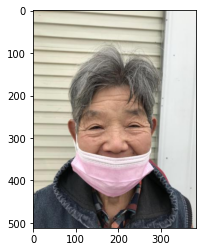

In [141]:
idx = 1020
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = tfms_test(image=image)['image'].to(device)
image = image.unsqueeze(0)
m_pred, g_pred, a_pred = model(image)

m_argmax = m_pred.detach().cpu().numpy().argmax(1)
g_argmax = g_pred.detach().cpu().numpy().argmax(1)
a_argmax = a_pred.detach().cpu().numpy().argmax(1)

#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}
#
print(masklabel[m_argmax[0]]+ " :", (m_pred[0][m_argmax].item())*100, '%')
print(genderlabel[g_argmax[0]]+ " :", (g_pred[0][g_argmax].item())*100, '%')
print(agelabel[a_argmax[0]]+ " :", (a_pred[0][a_argmax].item())*100, '%')
